In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import tri, cm
import meshio

Definições Geométricas

In [4]:
msh = meshio.read('new_cube.msh')

X = msh.points[:,0]
Y = msh.points[:,1]
Z = msh.points[:,2]

In [22]:
IEN = np.array([])
IENBound = np.array([])

for cellBlock in msh.cells:
    if cellBlock.type == 'triangle':
        if IENBound.shape == (0,):
            IENBound = cellBlock.data
        else:
            IENBound = np.concatenate([IENBound, cellBlock.data])
    elif cellBlock.type == 'tetra':
        if IEN.shape == (0,):
            IEN = cellBlock.data
        else:
            IEN = np.concatenate([IEN, cellBlock.data])

In [23]:
IEN

array([[2853, 4235, 3445, 6766],
       [ 639, 3592,  246, 4448],
       [2915, 3917, 3571, 5355],
       ...,
       [ 283,  284, 6807,  285],
       [1848, 5333, 1936, 6937],
       [1848, 1936, 5333, 1931]])

In [24]:
IENBound

array([[  26,    0,  655],
       [   0,   27,  655],
       [   1,    8,  656],
       ...,
       [2735, 2769, 2768],
       [2798, 2803, 2738],
       [2798, 2827, 2803]])

In [25]:
Npoints = len(X)
ne = IEN.shape[0]

In [ ]:
# IENboundTypeElem = list(msh.cell_data['gmsh:physical'][0] - 1)
# boundNames = list(msh.field_data.keys())
# IENboundElem = [boundNames[elem] for elem in IENboundTypeElem]
# npoints = len(X)
# ne = IEN.shape[0]

In [ ]:
# # cria lista de nos do contorno
# cc = np.unique(IENbound.reshape(IENbound.size))
# ccName = [[] for i in range( len(X) )]
# for elem in range(0,len(IENbound)):
#  ccName[ IENbound[elem][0] ] = IENboundElem[elem]
#  ccName[ IENbound[elem][1] ] = IENboundElem[elem]
#  ccName[ IENbound[elem][2] ] = IENboundElem[elem]
# # plot malha e pontos de contorno (export para vtk)
# meshio.write_points_cells('malha.vtk',
#  msh.points,
#  msh.cells,)

In [28]:
cc = np.unique(IENBound.reshape(IENBound.size))
meshio.write_points_cells('malha.vtk',
 msh.points,
 msh.cells,)

Definições do material

In [29]:
rho = 1
cv = 1
alpha = 1

kappa = [1, 1, 1] # kx, ky, kz

Q = -6*rho*cv

In [7]:
# X = np.linspace(0, Lx, Nx, dtype = float)
# Y = np.linspace(0, Ly, Ny, dtype = float)
# Z = np.linspace(0, Lz, Nz, dtype = float)

# Yv, Xv, Zv = np.meshgrid(Y, X, Z)

# X = np.reshape(Xv, Npoints)
# Y = np.reshape(Yv, Npoints)
# Z = np.reshape(Zv, Npoints)

In [91]:
# for i in range(8):
#     print(X[i], Y[i], Z[i])

0.0 0.0 1.0
0.0 0.0 0.0
0.0 1.0 1.0
0.0 1.0 0.0
1.0 0.0 1.0
1.0 0.0 0.0
1.0 1.0 1.0
1.0 1.0 0.0


In [9]:
# ## IEN 
# # 0  ,  nx      ,  nx + 1 : type 1
# # 0  ,  nx + 1  ,  1      : type 2

# IEN = [
#     [0, 2, 3, 6],
#     [3, 1, 0, 5],
#     [0, 6, 5, 4],
#     [0, 2, 3, 6],
#     [0, 2, 3, 6],
# ]

In [ ]:
# for i in range(Ny - 1):
    
#     for j in range(Nx - 2):
#         IEN.append([IEN[-2][k] + 1 for k in range(3)])
#         IEN.append([IEN[-2][k] + 1 for k in range(3)])

#     if i < Ny - 2:
#         IEN.append([IEN[0][k] + Nx*(i + 1) for k in range(3)])
#         IEN.append([IEN[1][k] + Nx*(i + 1) for k in range(3)])

In [30]:
#form functions for 2D
def IENfunc3DTet(K, M, IEN):
    for IENelem in IEN:
        x_list = [X[elem] for elem in IENelem]
        y_list = [Y[elem] for elem in IENelem]
        z_list = [Z[elem] for elem in IENelem]

        tet_matrix = np.array([[1, X[IENelem[i]], Y[IENelem[i]] , Z[IENelem[i]]] for i in range(4)])
        tet_volume = np.linalg.det(tet_matrix)/6

        # b_list = np.zeros(4, dtype = "float64") 
        # c_list = np.zeros(4, dtype = "float64") 
        # d_list = np.zeros(4, dtype = "float64")

        # for i in range(3):
        #     b_list[i] = (y_list[(i + 1)%4 - y_list[(i + 3)%4]])(z_list[(i + 2)%4] - z_list[(i + 3)%4]) - (y_list[(i + 2)%4] - y_list[(i + 3)%4])(z_list[(i + 1)%4] - z_list[(i + 3)%4])
        #     c_list[i] = (x_list[(i + 2)%4 - x_list[(i + 3)%4]])(z_list[(i + 1)%4] - z_list[(i + 3)%4]) - (x_list[(i + 1)%4] - x_list[(i + 3)%4])(z_list[(i + 2)%4] - z_list[(i + 3)%4])
        #     d_list[i] = (x_list[(i + 1)%4 - x_list[(i + 3)%4]])(y_list[(i + 2)%4] - y_list[(i + 3)%4]) - (x_list[(i + 2)%4] - x_list[(i + 3)%4])(y_list[(i + 1)%4] - y_list[(i + 3)%4])

        # b_list[3] = -sum(b_list) 
        # c_list[3] = -sum(c_list) 
        # d_list[3] = -sum(d_list) 

        melem = (tet_volume/20)*np.array(([2, 1, 1, 1],
                                          [1, 2, 1, 1],
                                          [1, 1, 2, 1],
                                          [1, 1, 1, 2]))
        
        [a_list, b_list, c_list, d_list] = np.linalg.inv(tet_matrix)
        
        kxelem = kappa[0]*tet_volume*np.array([[b_list[i]*b_list[j] for i in range(4)] for j in range(4)])
        kyelem = kappa[1]*tet_volume*np.array([[c_list[i]*c_list[j] for i in range(4)] for j in range(4)])
        kzelem = kappa[2]*tet_volume*np.array([[d_list[i]*d_list[j] for i in range(4)] for j in range(4)])

        kelem = kxelem + kyelem + kzelem

        for ilocal in range(4):
            iglobal = IENelem[ilocal]

            for jlocal in range(4):
                jglobal = IENelem[jlocal]

                K[iglobal,jglobal] += kelem[ilocal,jlocal]
                M[iglobal,jglobal] += melem[ilocal,jlocal]

In [31]:
K  = np.zeros((Npoints, Npoints), dtype = float) 
M  = np.zeros((Npoints, Npoints), dtype = float)

IENfunc3DTet(K, M, IEN)

In [32]:
qvec = np.full(Npoints, Q/(rho*cv))

A = K.copy()
b = M@qvec

In [33]:
# Boundary conditions
Tcc = lambda x, y, z: x*x + y*y + z*z

In [ ]:
# nos de condicao de contorno
cc1 = np.arange(           start = 0,           stop = Nx,  step = 1) # bottom 
cc2 = np.arange(          start = Nx, stop = Npoints - Nx, step = Nx) # left
cc3 = np.arange(start = Npoints - Nx,      stop = Npoints,  step = 1) # top
cc4 = np.arange(    start = 2*Nx - 1, stop = Npoints - Nx, step = Nx) # right

cc = np.hstack([cc1,cc2,cc3,cc4])

In [35]:
for i in cc:
    A[i,:] = 0.0
    A[i,i] = 1
    b[i] = Tcc(X[i], Y[i], Z[i])

In [36]:
A_inv = np.linalg.inv(A)

In [37]:
T_vec = A_inv@b
# T_mat = A_inv@b

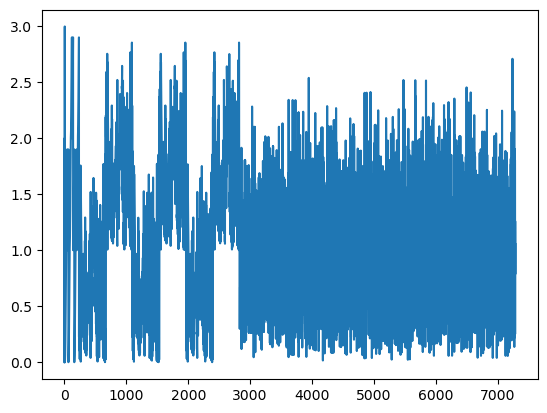

In [41]:
plt.plot(T_vec)
plt.show()

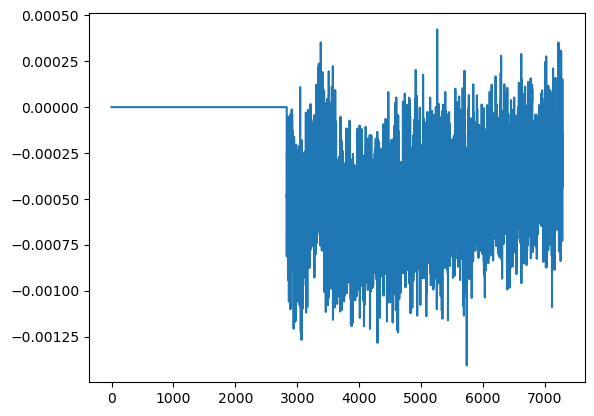

In [40]:
plt.plot(T_vec - Tcc(X, Y, Z))
plt.show()

In [101]:
triang = tri.Triangulation(X,Y)

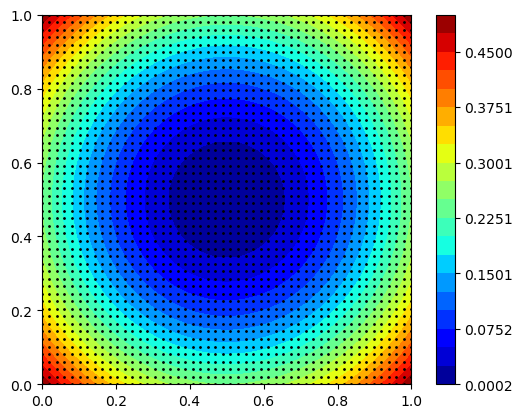

In [104]:
# For graphical purposes
Tmin = min(T_vec)
Tmax = max(T_vec)

# Temperature contourplot
ax = plt.axes()
ax.set_aspect('equal')
ax.triplot(triang,'ko-', markersize = 1)
surf = ax.tricontourf(triang,T_vec,cmap='jet', levels = np.linspace(Tmin, Tmax, 21))
plt.colorbar(surf)
plt.show()

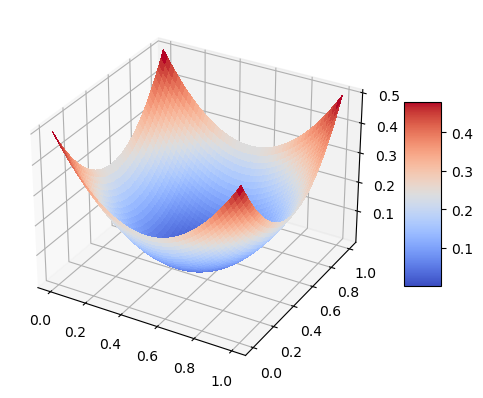

In [105]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
Xz = np.reshape(X, (Nx, Ny))
Yz = np.reshape(Y, (Nx, Ny))
Tz = np.reshape(T, (Nx, Ny))

# Plot the surface.
surf = ax.plot_surface(Xz, Yz, Tz, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()